# Notebook Goals
Use some pretrained out-of-the-box models from pytorch to see how well it does, these will serve as benchmark algorithms to our custom model. The pretrained models will be finetuned

Other performance metrics: https://medium.com/analytics-vidhya/how-to-select-performance-metrics-for-classification-models-c847fe6b1ea3

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
import torchvision
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from sklearn.metrics import confusion_matrix, classification_report


# Reproducability
# https://clay-atlas.com/us/blog/2021/08/24/pytorch-en-set-seed-reproduce/
seed = 123
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [2]:
TRAIN_IMGS = "../input/children-vs-adults-images/train"
TEST_IMGS = "../input/children-vs-adults-images/test"
PATH = "./Model.pth"

In [3]:
# Hyperparameters
IMG_SIZE = (224,224)
BATCH_SIZE = 32
NUM_EPOCHS = 25
LR = 0.001

In [4]:
# Transforms
transforms = {'train': transforms.Compose([transforms.Resize(IMG_SIZE),
                                           transforms.RandomHorizontalFlip(p=0.5),
                                           transforms.RandomVerticalFlip(p=0.5),
                                           transforms.ColorJitter(brightness=.5, contrast=.3, saturation=.2),
                                 transforms.ToTensor()]), 
              
              'test': transforms.Compose([transforms.Resize(IMG_SIZE),
                                          transforms.RandomHorizontalFlip(p=0.5),
                                           transforms.RandomVerticalFlip(p=0.5),
                                          transforms.ColorJitter(brightness=.5, contrast=.3, saturation=.2),
                                 transforms.ToTensor()])
             }

In [5]:
dataset = ImageFolder(TRAIN_IMGS, transform=transforms['train'])
test_dataset = ImageFolder(TEST_IMGS, transform=transforms['test'])

In [6]:
# Split dataset into train and valid, 75% and 25%
train_set, validation_set = random_split(dataset, [510, 170]) # total number of datapoints = 680
train_dl = DataLoader(train_set, BATCH_SIZE, shuffle=True)
val_dl = DataLoader(validation_set, BATCH_SIZE, shuffle=True)

test_dl = DataLoader(test_dataset, BATCH_SIZE, shuffle=True) # if you dont, then first batch will be all 0

torch.Size([32, 3, 224, 224]) torch.Size([32])
tensor(1)


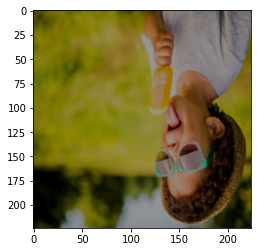

In [7]:
# Display an img
img, label = next(iter(train_dl))
print(img.shape, label.shape)
img = img[0].squeeze() # gets rid of batch column, returns [3, 224, 224]
label = label[0]

plt.imshow(img.permute(1, 2, 0)) # from [c, w, h] to [w, h, c]
print(label)

In [8]:
# Using pretrained models
resnet18 = torchvision.models.resnet18(pretrained=True)

# Change last layer of model to represent number of classes, in this case 0 = adult, 1 = child. 
resnet18.fc = nn.Linear(in_features=512, out_features=2, bias=True)
#resnet18

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [10]:
# Training Function 
# https://learn.microsoft.com/en-us/windows/ai/windows-ml/tutorials/pytorch-analysis-train-model
def train(model): 
    model = model.to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=LR)
    running_train_loss_arr = []
    running_val_loss_arr = []
     
    for epoch in range(NUM_EPOCHS): 
        running_train_loss = 0.0 
        running_accuracy = 0.0 
        running_vall_loss = 0.0 
        total = 0 
        
 
        # Training Loop 
        for data in train_dl: 
        #for data in enumerate(train_loader, 0): 
            inputs, outputs = data  # get the input and real species as outputs; data is a list of [inputs, outputs] 
            inputs = inputs.to(device)
            outputs = outputs.to(device)
            optimizer.zero_grad()   # zero the parameter gradients          
            predicted_outputs = model(inputs)   # predict output from the model 
            train_loss = loss_fn(predicted_outputs, outputs)   # calculate loss for the predicted output  
            train_loss.backward()   # backpropagate the loss 
            optimizer.step()        # adjust parameters based on the calculated gradients 
            running_train_loss +=train_loss.item()  # track the loss value 
 
        # Calculate training loss value 
        train_loss_value = running_train_loss/len(train_dl) 
        running_train_loss_arr.append(train_loss_value)
 
        # Validation Loop 
        with torch.no_grad(): 
            model.eval() 
            for data in val_dl: 
                inputs, outputs = data 
                inputs = inputs.to(device)
                outputs = outputs.to(device)
                predicted_outputs = model(inputs) 
                val_loss = loss_fn(predicted_outputs, outputs) 
             
                # The label with the highest value will be our prediction 
                _, predicted = torch.max(predicted_outputs, 1) 
                running_vall_loss += val_loss.item()  
                total += outputs.size(0) 
                running_accuracy += (predicted == outputs).sum().item() 
 
        # Calculate validation loss value 
        val_loss_value = running_vall_loss/len(val_dl) 
        running_val_loss_arr.append(val_loss_value)
                
        # Calculate accuracy as the number of correct predictions in the validation batch divided by the total number of predictions done.  
        accuracy = (100 * running_accuracy / total)     
         
        # Print the statistics of the epoch 
        print(f'[{epoch + 1}/{NUM_EPOCHS}], Training Loss is: {train_loss_value:.3f}, Validation Loss is: {val_loss_value:.3f},Accuracy is {accuracy:.3f}')
        
        # Save the model 
        torch.save(model.state_dict(), PATH)
    return running_train_loss_arr, running_val_loss_arr
        

In [11]:
def plt_loss(train_loss, val_loss):
    plt.title('Train')
    plt.ylabel('Loss')
    plt.xlabel('Batches')
    plt.plot(train_loss)
    plt.plot(val_loss)
    plt.legend(['Train', 'Validation'])

In [12]:
# Test model on test data
def test(model):
    model.load_state_dict(torch.load(PATH)) 
    model = model.to(device)
    predictions = []
    targets = []
    running_accuracy = 0.0
    
    with torch.no_grad():
        for img, labels in test_dl:
            img = img.to(device)
            labels = labels.to(device)
            output = model(img)
            pred = torch.argmax(output, 1)
            
            # Calculate accuracy
            
            # For confusion matrix
            # https://stackoverflow.com/questions/63647547/how-to-find-confusion-matrix-and-plot-it-for-image-classifier-in-pytorch
            # convert to np array
            pred = pred.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
            
            for i in range(len(pred)):
                predictions.append(pred[i])
                targets.append(labels[i])
            
    
    return predictions, targets

In [13]:
def cfm_class_report(predictions, targets):
    # https://vitalflux.com/python-draw-confusion-matrix-matplotlib/
    cfm = confusion_matrix(predictions, targets)
    plt.matshow(cfm, cmap=plt.cm.Blues, alpha=0.3) #display array as matrix
    for i in range(cfm.shape[0]):
        for j in range(cfm.shape[1]):
            plt.text(x=j, y=i, s=cfm[i, j], va='center', ha='center')
    plt.xlabel('Predictions')
    plt.ylabel('Actual')
    plt.title('Test Confusion Matrix')
    
    print(classification_report(targets, predictions, target_names=['Adult', 'Child']))
    #print(cfm) # in array form

[1/25], Training Loss is: 0.691, Validation Loss is: 0.697,Accuracy is 54.706
[2/25], Training Loss is: 0.654, Validation Loss is: 0.623,Accuracy is 61.176
[3/25], Training Loss is: 0.614, Validation Loss is: 0.622,Accuracy is 67.647
[4/25], Training Loss is: 0.568, Validation Loss is: 0.587,Accuracy is 67.647
[5/25], Training Loss is: 0.540, Validation Loss is: 0.631,Accuracy is 69.412
[6/25], Training Loss is: 0.509, Validation Loss is: 0.518,Accuracy is 74.706
[7/25], Training Loss is: 0.479, Validation Loss is: 0.564,Accuracy is 75.882
[8/25], Training Loss is: 0.509, Validation Loss is: 0.485,Accuracy is 77.059
[9/25], Training Loss is: 0.452, Validation Loss is: 0.493,Accuracy is 74.706
[10/25], Training Loss is: 0.434, Validation Loss is: 0.523,Accuracy is 69.412
[11/25], Training Loss is: 0.432, Validation Loss is: 0.516,Accuracy is 71.765
[12/25], Training Loss is: 0.416, Validation Loss is: 0.514,Accuracy is 74.118
[13/25], Training Loss is: 0.403, Validation Loss is: 0.621,A

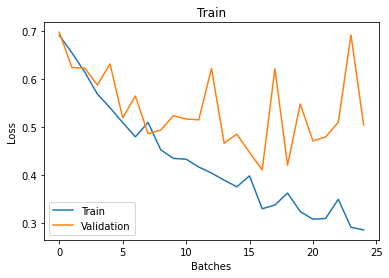

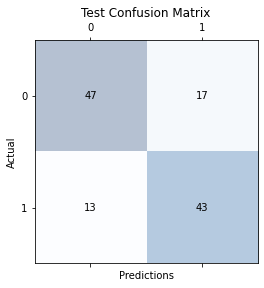

In [14]:
if __name__ == "__main__":
    train_loss, val_loss = train(resnet18)
    plt_loss(train_loss, val_loss)
    predictions, targets = test(resnet18)
    cfm_class_report(predictions, targets)